# **EDA King County Housing Data**

**Stakeholder:** Thomas Hansen.

**Thomas situation:** Thomas wants to buy a house. He has 5 children, no money and would like to know where suitable houses are located and when it is cheap to buy.

Main Questions:

1. Where to buy buy house
2. When to buy house

Requirements:
1. Neighborhood is not a ghetto
2. Neighborhood is lively (no village)
3. House has enough space for 1 adult and 5 children
4. House is cheap




## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import altair as alt
import pandas as pd
import statsmodels.api as sms

## Import dataframe 


* get an overview

In [2]:
house = pd.read_csv('../data/King_County_House_prices_dataset.csv')
house.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Create new variables

1. Price per Squarefoot (price_sqft)
2. Month when house was sold (month_sold)

In [3]:
# price per sqft
house['price_sqft'] = house.price / house.sqft_living
new_house = house.copy()


# month_sold
new_house['date']=pd.to_datetime(new_house['date'],format='%m/%d/%Y')
new_house['month_sold'] = new_house['date'].dt.month

## Filter dataframe to get relevant data

**Assumptions:**

* Where many houses are sold, there tend to be more houses -> **lively neighborhood** - neighborhoods are taken that are above the median of the sum of sold houses per zip code.
* Quiet uncrowded neighborhoods are more likely to be in the countryside and Houses have large lots -> If the 25% quartile of the land lots within the zip code is greater than the median of the land lots of all areas the zipcode is going to be filtered out.
* The worst neighborhoods have the lowest price per square foot -> zip codes within the 75% quartile is lower than the 25% quartile of all neighborhoods are going to be filtered out.
* Thomas needs at least 4 bedrooms and 1184 square feet of living space




In [4]:
# median sqft land lot
# new_house.sqft_lot15.describe()

# take median zipcodes = 282 houses per zipcode
new_house.groupby('zipcode').count().id.describe()

count     70.000000
mean     308.528571
std      142.223820
min       50.000000
25%      204.250000
50%      282.500000
75%      408.250000
max      602.000000
Name: id, dtype: float64

## Filter Dataframe

* to filter the data I have created lists with zipcodes

In [5]:
# median land lot sqft 7620 

big = new_house.groupby('zipcode').sqft_lot15.describe()['25%'].reset_index()
big = big[big['25%'] > 7620]
big_list = big.zipcode.to_list()

# Q25 price per sqft = 177

ghetto = new_house.groupby('zipcode').price_sqft.describe()["75%"].reset_index()
ghetto = ghetto[ghetto['75%'] < 177]
ghetto_list = ghetto.zipcode.to_list()

# filter the zipcodes with more sold houses (bigger than median) and add them to the list zips

top_zip = new_house.groupby('zipcode').count().query('id > 282').reset_index()
zips = top_zip.zipcode.to_list()

# filter dataframe
new_house = new_house.query('zipcode in @zips and zipcode not in @ ghetto_list and zipcode not in @big_list and sqft_living > 1184 and bedrooms >= 4 ')


* for a better overview I have created the new dataframe **final**, which contains only the variables that are of interest
* in addition I have created a new dataframe in which longitudinal and lateral geodata is added to each zipcode, as well as the median square foot price in this zipcode
* the name of this dataframe is **final_frame**
* i build **final_frame** for better geo plotting

In [6]:
# new dataframe with relevant variables

final = new_house[['price', 'bedrooms', 'sqft_living', 'zipcode', 'month_sold', 'lat', 'long', 'price_sqft']].copy()

# new dataframe final_frame

final_long = final.groupby('zipcode').describe().long['mean'].reset_index()
final_long.rename(columns={'mean': 'long'}, inplace=True)
final_lat = final.groupby('zipcode').describe().lat['mean'].reset_index()
final_lat.rename(columns={'mean': 'lat'}, inplace=True)
final_zips = pd.merge(final_lat, final_long, on='zipcode')
final_price = final.groupby('zipcode').describe().price_sqft['50%'].reset_index()
final_price.rename(columns={'50%': 'price_sqft'}, inplace=True)
final_frame = pd.merge(final_zips, final_price, on='zipcode')
final_frame

,zipcode,lat,long,price_sqft
0,98027,47.521279,-122.042160,237.797619
1,98029,47.559866,-122.005601,262.155963
2,98033,47.678550,-122.188681,303.582463
3,98034,47.719788,-122.207249,230.013774
4,98038,47.368190,-122.030838,160.169366
5,98042,47.365059,-122.119729,143.949618
6,98052,47.682587,-122.116453,263.801067
7,98053,47.669609,-122.023102,239.905956
8,98056,47.510836,-122.184169,186.933357
9,98058,47.444748,-122.142493,160.944206


## Create plots to show Results

### 1. Plot 

* shows all possible neighborhoods after filtering the data on the map

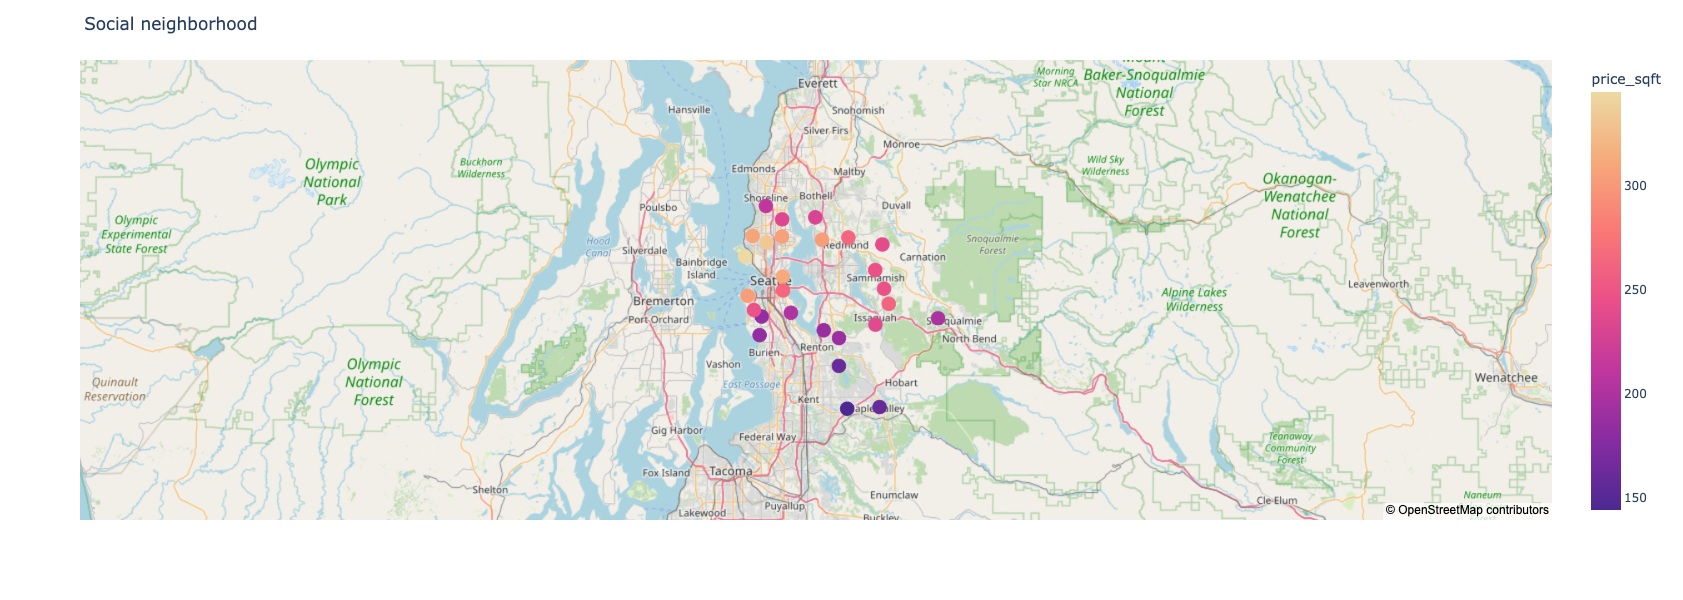

In [87]:
fig = px.scatter_mapbox(final_frame, lat=final_frame.lat, lon=final_frame.long, width=800, height=600, color="price_sqft")
# change default for continuous color scale
px.defaults.color_continuous_scale = px.colors.sequential.Agsunset
fig.update_geos(fitbounds='locations')
fig.update_layout(title="Social neighborhood")

fig.update_traces(marker=dict(size=15))
fig.update_layout(mapbox_style="open-street-map")
fig.show()

### 2. Plot 

* shows the top three neighborhoods with regard to the price per square foot 


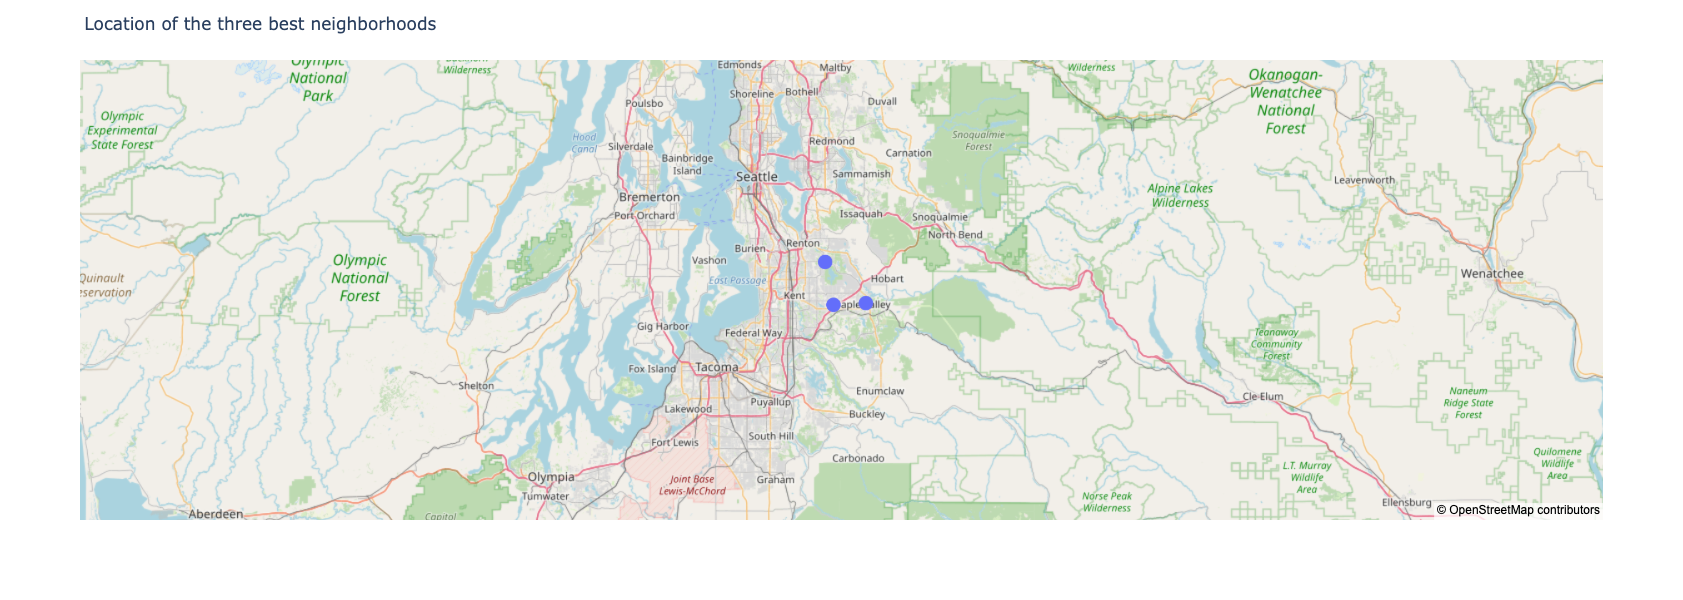

In [88]:
top3_zip = [98042, 98038, 98058]
top = final_frame.query('zipcode in @top3_zip')

fig = px.scatter_mapbox(top, lat=top.lat, lon=top.long, width=800, height=600)
 
fig.update_geos(fitbounds='locations')
fig.update_layout(mapbox_style="open-street-map", title="Location of the three best neighborhoods")
fig.update_traces(marker=dict(size=15))
fig.show()

## 3. Plot

* comparison of average price per square foot bewteen **all neighborhoods** with the **nice neighborhoods** as well as the **top three neighborhoods (nice%cheap)**

,price,bedrooms,sqft_living,zipcode,month_sold,lat,long,price_sqft
count,6.880000e+02,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,3.912957e+05,4.158430,2503.082849,98045.453488,6.694767,47.391173,-122.092475,157.542241
std,1.320122e+05,0.395997,692.224588,8.623663,3.118219,0.040525,0.056597,29.162383
min,1.640000e+05,4.000000,1200.000000,98038.000000,1.000000,47.311700,-122.187000,91.690544
25%,3.200000e+05,4.000000,2007.500000,98038.000000,4.000000,47.357100,-122.148000,138.485639
50%,3.615000e+05,4.000000,2400.000000,98042.000000,7.000000,47.376400,-122.094500,155.174102
75%,4.285250e+05,4.000000,2820.000000,98058.000000,9.000000,47.434100,-122.037750,174.691336
max,1.500000e+06,6.000000,7320.000000,98058.000000,12.000000,47.475300,-121.958000,336.956522


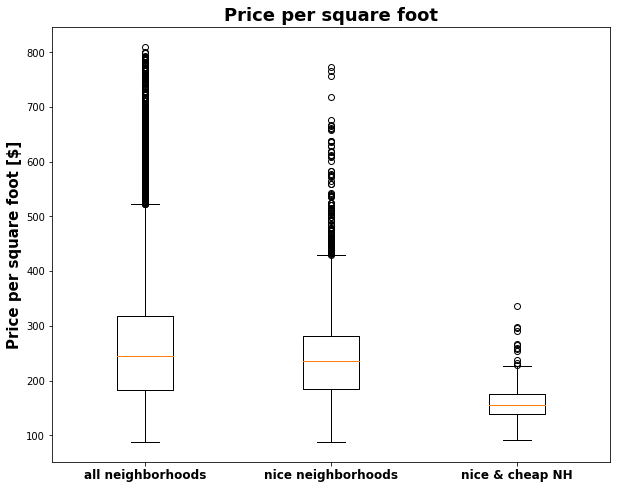

In [89]:
nice = final.query('zipcode in @top3_zip')
house_list = house.price_sqft.to_list()
new_house_list = final.price_sqft.to_list()
top_list = nice.price_sqft.to_list()
dic = {'all neighborhoods': house_list, 'nice neighborhoods': new_house_list, 'nice & cheap NH': top_list}


fig, ax = plt.subplots()
ax.boxplot(dic.values())
ax.set_xticklabels(dic.keys())
ax.set_ylabel('Price per square foot [$]', fontsize=15, fontweight='bold')
ax.set_title('Price per square foot', fontsize=18, fontweight='bold')
ax.set_xticklabels(dic.keys(), fontsize=12, fontweight='bold')
fig.set_size_inches(10, 8, forward=True)


* range of prices per square foot become lower as filter increases

## 4. Plot - Timing?!

* The graph is intended to show the changes in price per square foot within the top 3 neighborhoods over the months
* In addition, the number of home sales per month should be presented too


In [15]:
# building two lists for plotting "Sales & sqft price per month

sells = nice.groupby('month_sold').count().reset_index()
sells_list = sells.price.to_list() # list list of all house sales per month

sqft = nice.groupby('month_sold').describe().price_sqft.reset_index()
sqft_list = sqft['mean'].to_list() # list of mean price per sqft per month


/var/folders/v2/f3sfsr9j3l301s3vz3y_712c0000gn/T/ipykernel_41086/3574617940.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



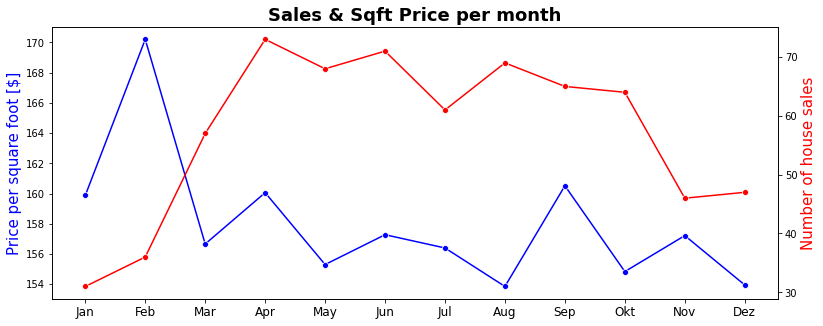

In [67]:
x = month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Okt','Nov','Dez']
y = sqft_list
y1 = sells_list

fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.lineplot(x = x, y = y, ax = ax1, marker = 'o', color = 'blue') # plots the first set of data, and sets it to ax1. 
sns.lineplot(x = x, y = y1, marker = 'o', color = 'red', ax = ax2) # plots the second set, and sets to ax2. 

# these lines add the annotations for the plot. 

ax1.set_ylabel('Price per square foot [$]', color='b',fontsize=15)
ax2.set_ylabel('Number of house sales', color='r', fontsize=15)
ax1.set_title('Sales & Sqft Price per month', fontsize=18, fontweight='bold')
ax1.set_xticklabels(x, fontsize=12)

fig.set_size_inches(13, 5, forward=True)
plt.show()


* the price seems to behave typically according to the supply and demand principle -> the more houses are sold per month, the cheaper the square foot price becomes
* according to these data it is not recommended to buy at the beginning of the year
* the second half of the year seems to be the best time to buy

### Let's take a look to the next graph! 

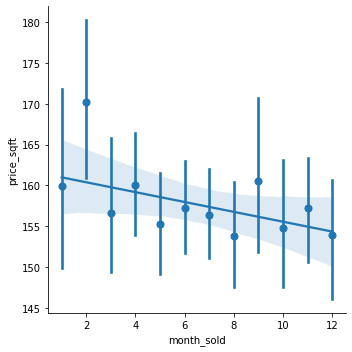

In [14]:
import numpy as np
sns.lmplot(x='month_sold', y='price_sqft', data=nice, x_estimator=np.mean)

* the regression line showed a slight downward trend with regard to the price per square meter over the year, but no significance can be determined here on the basis of a regression analysis.

In [ ]:
# Prepare data for modeling
# Choose the predictor and add a constant term
X = top.month_sold
y = top.price_sqft_x
X = sms.add_constant(X)

# Create an OLS model
model = sms.OLS(y, X)
# use the data to calculate the intercept and slope
results = model.fit()
# return the output of the model
results.summary()

In [101]:
gesamt = house.query('zipcode in @top3_zip')
gesamt.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_sqft
count,1.591000e+03,1.591000e+03,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1409.0,1585.000000,1591.000000,1591.000000,1591.00000,1591.000000,1321.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000
mean,4.249672e+09,3.441534e+05,3.451917,2.211031,2062.798240,21515.908234,1.554997,0.0,0.027760,3.383407,7.527970,1912.00000,1987.604023,46.883422,98045.094909,47.390517,-122.093221,2022.058454,16444.191703,171.793842
std,2.896869e+09,1.252933e+05,0.709359,0.578008,732.156549,54496.823171,0.492355,0.0,0.269186,0.623503,0.946528,713.81683,17.327815,302.556291,8.342687,0.040082,0.056061,563.883090,30986.951997,39.658421
min,1.190014e+07,9.500000e+04,1.000000,0.750000,650.000000,1561.000000,1.000000,0.0,0.000000,1.000000,4.000000,650.00000,1904.000000,0.000000,98038.000000,47.311700,-122.187000,399.000000,2243.000000,88.000000
25%,1.796371e+09,2.699250e+05,3.000000,1.750000,1560.000000,5701.000000,1.000000,0.0,0.000000,3.000000,7.000000,1330.00000,1976.000000,0.000000,98038.000000,47.360100,-122.148000,1610.000000,5636.000000,146.912792
50%,3.223069e+09,3.250000e+05,3.000000,2.500000,1970.000000,7750.000000,2.000000,0.0,0.000000,3.000000,7.000000,1820.00000,1990.000000,0.000000,98042.000000,47.374400,-122.090000,1980.000000,7700.000000,167.968750
75%,6.702925e+09,3.900000e+05,4.000000,2.500000,2470.000000,11494.500000,2.000000,0.0,0.000000,4.000000,8.000000,2370.00000,2003.000000,0.000000,98058.000000,47.432400,-122.041000,2380.000000,9997.000000,189.398715
max,9.558051e+09,1.500000e+06,6.000000,5.500000,7320.000000,982998.000000,3.000000,0.0,4.000000,5.000000,11.000000,7320.00000,2014.000000,2015.000000,98058.000000,47.477100,-121.936000,4443.000000,298182.000000,585.769231


In [100]:
house.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_sqft
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,264.143368
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950,110.000061
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,87.588235
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,182.291667
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,244.644550
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,318.333333
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,810.138889
